<a href="https://colab.research.google.com/github/elinsun/beer-recommendation-system/blob/master/Final%20Submission/compare_model_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beer Recommendation
Fall 2018, 4571 Recommendation System Final Project

- Scalability: compare the performance of different algorithms among users/items with different number of reviews



## Part 1: Data Preprocessing

In [1]:
# based on Google Colab 
# python 3
!pip install scikit-surprise

In [0]:
import pandas as pd
import numpy as np
import os
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
from surprise.model_selection import train_test_split
from surprise import NMF, Reader, Dataset, SVD, NMF, accuracy, KNNWithMeans

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.1 Load Data

In [0]:
# load metadata from Google Drive 
# save as a list
data = []
one_complete_review = []

with open('/content/gdrive/My Drive/beeradvocate.txt', 'r') as f:
  for i in f: 
    #row = i.decode(encoding = 'UTF-8',errors = 'ignore')
    row = i.replace('beer/', 'beer_').replace('review/','review_') 
    if row == '\n':
      data.append(one_complete_review)
      one_complete_review = []
      continue
    row = row.split(": ", 1)[1].rstrip()
    one_complete_review.append(row)

In [0]:
# convert list to dataframe
column_names = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']

df = pd.DataFrame.from_records(data, columns=column_names)

In [6]:
# descriptive 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
beer_name             1586614 non-null object
beer_beerId           1586614 non-null object
beer_brewer           1586614 non-null object
beer_ABV              1586614 non-null object
beer_style            1586614 non-null object
review_appearance     1586614 non-null object
review_aroma          1586614 non-null object
review_palate         1586614 non-null object
review_taste          1586614 non-null object
review_overall        1586614 non-null object
review_time           1586614 non-null object
review_profileName    1586614 non-null object
review_text           1586614 non-null object
dtypes: object(13)
memory usage: 157.4+ MB


In [7]:
df.head(3)

,beer_name,beer_beerId,beer_brewer,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
0,Sausa Weizen,47986,10325,5.00,Hefeweizen,2.5,2,1.5,1.5,1.5,1234817823,stcules,A lot of foam. But a lot.\tIn the smell some b...
1,Red Moon,48213,10325,6.20,English Strong Ale,3,2.5,3,3,3,1235915097,stcules,"Dark red color, light beige foam, average.\tIn..."
2,Black Horse Black Beer,48215,10325,6.50,Foreign / Export Stout,3,2.5,3,3,3,1235916604,stcules,"Almost totally black. Beige foam, quite compac..."


In [8]:
print('The full dataset includes:')
print('%d unique beers;' % df.beer_beerId.nunique())
print('%d unique users;' % df.review_profileName.nunique())
print('and %d reviews in total.' % df.shape[0])

The full dataset includes:
66055 unique beers;
33388 unique users;
and 1586614 reviews in total.


### 1.2 Exploratory Data Analysis

#### users

In [0]:
num_review_byuser = df.review_profileName.value_counts()
freq_list_user = np.array(list(dict(num_review_byuser).values()))

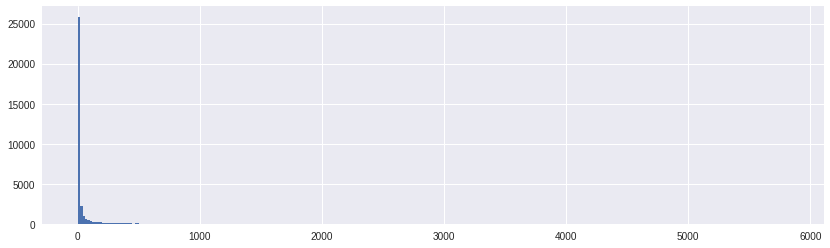

In [10]:
plt.figure(figsize=(14, 4))
plt.hist(freq_list_user, bins=300)
plt.show()

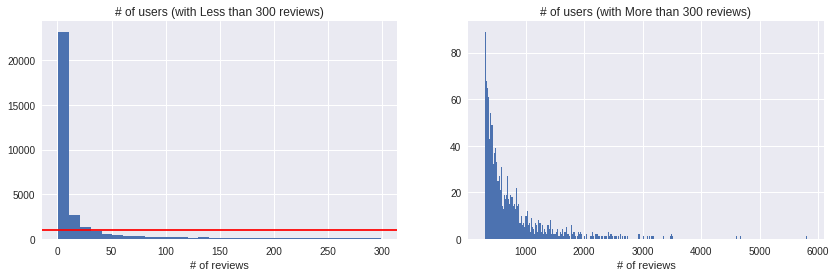

In [11]:
user5more = freq_list_user[np.where(freq_list_user >= 300)]
user5less = freq_list_user[np.where(freq_list_user < 300)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(user5less, bins=30)
plt.title('# of users (with Less than 300 reviews)')
plt.xlabel('# of reviews')
plt.axhline(y=1000, color='r', linestyle='-')

plt.subplot(122)
plt.hist(user5more, bins=300)
plt.title('# of users (with More than 300 reviews)')
plt.xlabel('# of reviews')

plt.show()

We have 33388 unique users, among them ~28000 users have less than 30 reviews.

#### beers

In [0]:
num_review_bybeer = df.beer_name.value_counts()
freq_list_beer = np.array(list(dict(num_review_bybeer).values()))

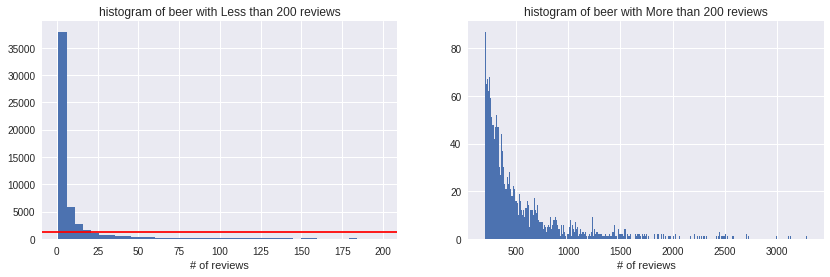

In [13]:
beer5more = freq_list_beer[np.where(freq_list_beer >= 200)]
beer5less = freq_list_beer[np.where(freq_list_beer < 200)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(beer5less, bins=40)
plt.title('histogram of beer with Less than 200 reviews')
plt.xlabel('# of reviews')
plt.axhline(y=1200, color='r', linestyle='-')

plt.subplot(122)
plt.hist(beer5more, bins=300)
plt.title('histogram of beer with More than 200 reviews')
plt.xlabel('# of reviews')

plt.show()

### 1.3 Subset from Metadata

In [14]:
# subset data for collabrotive filtering
df1 = df[['beer_name', 'beer_beerId', 'review_profileName', 'review_overall', 'review_time']]
print('Original data size: %s' % str(df1.shape)) 

# remove NA 
df1 = df1[pd.notnull(df1.beer_name) & pd.notnull(df1.review_profileName) & pd.notnull(df1.review_overall)]
# remove blanks
df1 = df1.loc[df1.review_profileName != '']
df1 = df1.loc[df1.beer_name != '']
df1 = df1.loc[df1.review_overall != '']
print('After removing NAs and blanks: %s' % str(df1.shape)) 

# drop duplicate (beer&user) pairs, keep the latest rating
df1['beer_user_pair'] = df1.beer_name + df1.review_profileName
df1 = df1.sort_values(by=['review_time'], ascending=False).drop_duplicates(subset=['beer_user_pair'])
print('After drop duplicate user-item pairs (only keep the latest rating), data size: %s' % str(df1.shape))

# convert review ratings to numberic
df1.review_overall = pd.to_numeric(df1.review_overall)

Original data size: (1586614, 5)
After removing NAs and blanks: (1586266, 5)
After drop duplicate user-item pairs (only keep the latest rating), data size: (1561405, 6)


In [15]:
df1.head(3)

,beer_name,beer_beerId,review_profileName,review_overall,review_time,beer_user_pair
581215,Pete's Wicked Strawberry Blonde,381,bk3nj,3.0,999999652,Pete's Wicked Strawberry Blondebk3nj
1023623,Fiji Bitter,1480,Mark,4.0,999980551,Fiji BitterMark
1077899,Wolaver's India Pale Ale,399,bcm119,3.5,999903142,Wolaver's India Pale Alebcm119


#### remove bottom users and beers

In [16]:
# subset three columns
cf = df1[['review_profileName', 'beer_name', 'review_overall']]

# sort user by # of reviews
cnt_user = dict(num_review_byuser)
cf['user_freq'] = [cnt_user.get(x) for x in cf.review_profileName]

# sort beer by # of reviews
cnt_beer = dict(num_review_bybeer)
cf['beer_freq'] = [cnt_beer.get(x) for x in cf.beer_name]

# drop users with less than 10 reviews
# drop beers with less than 5 reviews
cf = cf.loc[cf.user_freq > 10]
cf = cf.loc[cf.beer_freq > 5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
print('After removing bottom users and beers,')
print('%d unique beers;' % cf.beer_name.nunique())
print('%d unique users;' % cf.review_profileName.nunique())
print('and %d reviews in total.' % cf.shape[0])

After removing bottom users and beers,
18925 unique beers;
10189 unique users;
and 1423856 reviews in total.


In [18]:
cf.head(3)

,review_profileName,beer_name,review_overall,user_freq,beer_freq
581215,bk3nj,Pete's Wicked Strawberry Blonde,3.0,45,298
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257


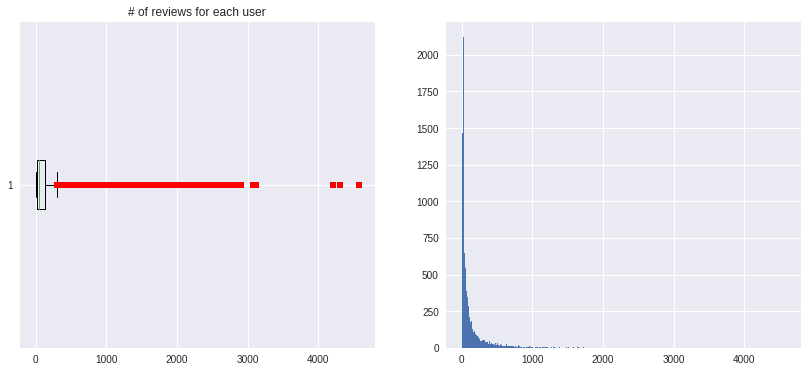

In [19]:
# user 
freq = cf.review_profileName.value_counts()
freq = np.array(list(dict(freq).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freq, 0, 'rs', 0)
plt.title('# of reviews for each user')

plt.subplot(122)
plt.hist(freq, bins=400)

plt.show()

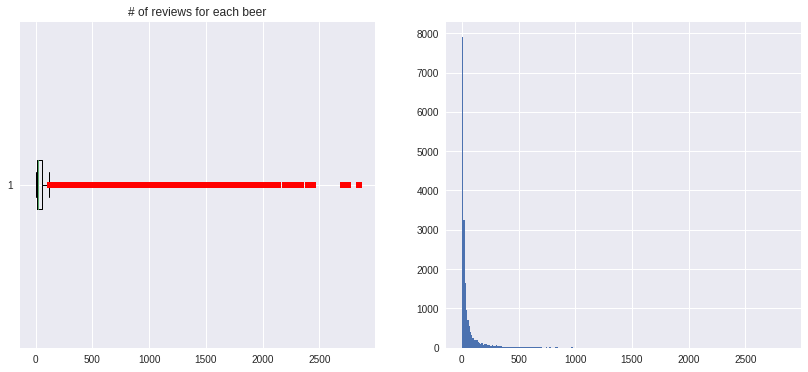

In [20]:
# beer
freqb = cf.beer_name.value_counts()
freqb = np.array(list(dict(freqb).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqb, 0, 'rs', 0)
plt.title('# of reviews for each beer')

plt.subplot(122)
plt.hist(freqb, bins=250)

plt.show()

#### split into two groups
- users with more than 100 reviews;
- users with less than 100 reviews.

In [21]:
# split into two groups
threshold = 100

more = cf.loc[cf.user_freq > threshold]
less = cf.loc[cf.user_freq <= threshold]

more.head()

,review_profileName,beer_name,review_overall,user_freq,beer_freq
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257
797362,Jason,Lindemans Framboise,3.5,2350,903
808675,Jason,Chapeau Framboise Lambic,4.0,2350,44
961766,Jason,Dooryard Ale,3.0,2350,13


group > 100 has the size: (1186781, 5)


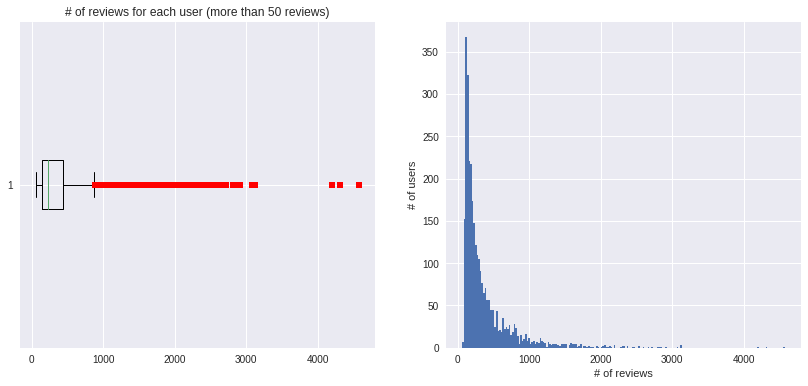

In [22]:
# visualize two groups
print('group > %d has the size: %s' % (threshold, str(more.shape)))

freqm = more.review_profileName.value_counts()
freqm = np.array(list(dict(freqm).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqm, 0, 'rs', 0)
plt.title('# of reviews for each user (more than 50 reviews)')

plt.subplot(122)
plt.hist(freqm, bins=200)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

group <= 100 has the size: (237075, 5)


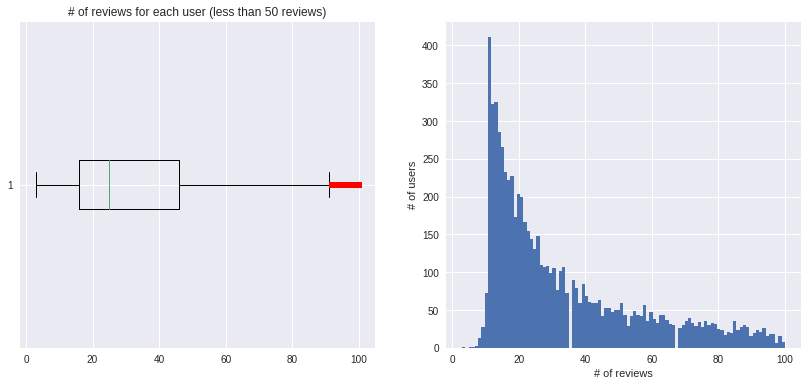

In [23]:
# visualize two groups
print('group <= %d has the size: %s' % (threshold, str(less.shape)))

freql = less.review_profileName.value_counts()
freql = np.array(list(dict(freql).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freql, 0, 'rs', 0)
plt.title('# of reviews for each user (less than 50 reviews)')

plt.subplot(122)
plt.hist(freql, bins=100)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

## Part 2: Prediction Models

In [0]:
# define functions to generate prediction dataframe
# get_Iu and get_Ui are borrowed from Surprise library
def get_Iu(uid):
    """Return the number of items rated by given user
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

# customized function to get predictions
def get_pred_df(pred):
  pred_df = pd.DataFrame(pred, columns=['uid', 'iid', 'rui', 'est', 'details'])    
  pred_df['Iu'] = pred_df.uid.apply(get_Iu)
  pred_df['Ui'] = pred_df.iid.apply(get_Ui)
  pred_df['err'] = abs(pred_df.est - pred_df.rui)
  
  # append review counts
  pred_df['user_freq'] = [cnt_user.get(x) for x in pred_df.uid]
  pred_df = pred_df.sort_values(by=['uid'])
  
  return pred_df

In [0]:
# train test split
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(cf[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset, testset = train_test_split(data, test_size=.33)

### 2.1 SVD

In [26]:
# fit
svd = SVD(n_factors = 30, lr_all = 0.01, reg_all = 0.05)
svd.fit(trainset)

# test 
svd_pred = svd.test(testset)
accuracy.rmse(svd_pred, verbose=True)

# predict
svd_pred_df = get_pred_df(svd_pred)
svd_pred_df.head()

RMSE: 0.5897


,uid,iid,rui,est,details,Iu,Ui,err,user_freq
100818,0110x011,Duchesse De Bourgogne,2.0,4.102216,{'was_impossible': False},102,736,2.102216,139
96356,0110x011,InFamous,4.0,4.314472,{'was_impossible': False},102,12,0.314472,139
464879,0110x011,Arctic Devil Barley Wine,4.0,4.383212,{'was_impossible': False},102,135,0.383212,139
69685,0110x011,Hoppe (Imperial Extra Pale Ale),3.0,4.218764,{'was_impossible': False},102,279,1.218764,139
436440,0110x011,Trappist Westvleteren 12,4.5,4.727700,{'was_impossible': False},102,777,0.227700,139


In [27]:
# predict on whole dataset
trainset_s, testset_s = train_test_split(data, test_size=.99)

svd_pred_s = svd.test(testset_s)
svd_pred_df_s = get_pred_df(svd_pred_s)
svd_pred_df_s.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
766001,0110x011,Ten FIDY,4.0,4.299918,{'was_impossible': False},102,1083,0.299918,139
620916,0110x011,90 Minute IPA,5.0,4.315196,{'was_impossible': False},102,1912,0.684804,139
959729,0110x011,Sierra Nevada Southern Hemisphere Harvest Fres...,4.5,4.267547,{'was_impossible': False},102,732,0.232453,139
598388,0110x011,Cape Cod IPA,3.5,4.230237,{'was_impossible': False},102,21,0.730237,139
1093132,0110x011,Stone Old Guardian Barley Wine Style Ale Aged ...,3.0,4.258619,{'was_impossible': False},102,16,1.258619,139


### 2.2 Non-negative Matrix Factorization (NMF)

In [28]:
# fit
nmf = NMF(n_factors = 25, n_epochs = 50, reg_pu = 0.1, reg_qi = 0.1)
nmf.fit(trainset)

# test 
nmf_pred = nmf.test(testset)
nmf_rmse = accuracy.rmse(nmf_pred, verbose=True) 
print('Test RMSE of NMF is %s' % round(nmf_rmse, 3))

# predict
nmf_pred_df = get_pred_df(nmf_pred)
nmf_pred_df.head()

RMSE: 0.5977
Test RMSE of NMF is 0.598


,uid,iid,rui,est,details,Iu,Ui,err,user_freq
100818,0110x011,Duchesse De Bourgogne,2.0,4.109565,{'was_impossible': False},102,736,2.109565,139
96356,0110x011,InFamous,4.0,4.274446,{'was_impossible': False},102,12,0.274446,139
464879,0110x011,Arctic Devil Barley Wine,4.0,4.438986,{'was_impossible': False},102,135,0.438986,139
69685,0110x011,Hoppe (Imperial Extra Pale Ale),3.0,4.290298,{'was_impossible': False},102,279,1.290298,139
436440,0110x011,Trappist Westvleteren 12,4.5,4.944133,{'was_impossible': False},102,777,0.444133,139


In [29]:
# predict on whole dataset
nmf_pred_s = nmf.test(testset_s)
nmf_pred_df_s = get_pred_df(nmf_pred_s)
nmf_pred_df_s.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
766001,0110x011,Ten FIDY,4.0,4.264586,{'was_impossible': False},102,1083,0.264586,139
620916,0110x011,90 Minute IPA,5.0,4.375750,{'was_impossible': False},102,1912,0.624250,139
959729,0110x011,Sierra Nevada Southern Hemisphere Harvest Fres...,4.5,4.344356,{'was_impossible': False},102,732,0.155644,139
598388,0110x011,Cape Cod IPA,3.5,4.333783,{'was_impossible': False},102,21,0.833783,139
1093132,0110x011,Stone Old Guardian Barley Wine Style Ale Aged ...,3.0,4.269051,{'was_impossible': False},102,16,1.269051,139


### 2.3 KNN user-based

#### 2.3.1 KNN on whole dataset (after trimmed)

In [30]:
# model set up
sim_options = {'name': 'pearson', 'user_based': True, 'min_support':10}  
knnmean = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)
# fit
knnmean.fit(trainset)

# test
knn_pred = knnmean.test(testset)

# predict
knn_pred_df = get_pred_df(knn_pred)
knn_pred_df.head()

Computing the pearson similarity matrix...
Done computing similarity matrix.


,uid,iid,rui,est,details,Iu,Ui,err,user_freq
100818,0110x011,Duchesse De Bourgogne,2.0,4.370442,"{'actual_k': 285, 'was_impossible': False}",102,736,2.370442,139
96356,0110x011,InFamous,4.0,4.313725,"{'actual_k': 9, 'was_impossible': False}",102,12,0.313725,139
464879,0110x011,Arctic Devil Barley Wine,4.0,4.583490,"{'actual_k': 98, 'was_impossible': False}",102,135,0.583490,139
69685,0110x011,Hoppe (Imperial Extra Pale Ale),3.0,4.520114,"{'actual_k': 149, 'was_impossible': False}",102,279,1.520114,139
436440,0110x011,Trappist Westvleteren 12,4.5,5.000000,"{'actual_k': 300, 'was_impossible': False}",102,777,0.500000,139


In [31]:
# predict whole dataset
knn_pred_s = knnmean.test(testset_s)
knn_pred_df_s = get_pred_df(knn_pred_s)
knn_pred_df_s.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
766001,0110x011,Ten FIDY,4.0,4.536693,"{'actual_k': 300, 'was_impossible': False}",102,1083,0.536693,139
620916,0110x011,90 Minute IPA,5.0,4.572465,"{'actual_k': 300, 'was_impossible': False}",102,1912,0.427535,139
959729,0110x011,Sierra Nevada Southern Hemisphere Harvest Fres...,4.5,4.562544,"{'actual_k': 300, 'was_impossible': False}",102,732,0.062544,139
598388,0110x011,Cape Cod IPA,3.5,4.423353,"{'actual_k': 10, 'was_impossible': False}",102,21,0.923353,139
1093132,0110x011,Stone Old Guardian Barley Wine Style Ale Aged ...,3.0,4.418318,"{'actual_k': 11, 'was_impossible': False}",102,16,1.418318,139


#### 2.3.2 KNN on two separate sets

In [0]:
# set up model
sim_options = {'name': 'pearson', 'user_based': True, 'min_support':10}  
knnmean1 = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)

knnmean2 = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)

##### 1) users with more than 100 reviews

In [33]:
# split train & test 
knn_more = Dataset.load_from_df(more[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset_more, testset_more = train_test_split(knn_more, test_size=.33)

# fit
knnmean1.fit(trainset_more)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [0]:
# test
pred_more = knnmean1.test(testset_more)

In [35]:
# prediction
pred_more_df = get_pred_df(pred_more)
pred_more_df.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
352546,0110x011,The Angel's Share - Bourbon Barrel-Aged,5.0,4.301306,"{'actual_k': 195, 'was_impossible': False}",102,337,0.698694,139
103180,0110x011,La Folie,5.0,4.372654,"{'actual_k': 249, 'was_impossible': False}",102,453,0.627346,139
296527,0110x011,Raspberry Tart,5.0,4.579579,"{'actual_k': 261, 'was_impossible': False}",102,460,0.420421,139
54746,0110x011,Consecration,4.5,4.600612,"{'actual_k': 279, 'was_impossible': False}",102,528,0.100612,139
111692,0110x011,Schlafly Oatmeal Stout,4.0,3.934061,"{'actual_k': 53, 'was_impossible': False}",102,125,0.065939,139


##### 2) users with less than 100 reviews

In [36]:
# split train & test 
knn_less = Dataset.load_from_df(less[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset_less, testset_less = train_test_split(knn_less, test_size=.33)

# fit
knnmean2.fit(trainset_less)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [37]:
# test
pred_less = knnmean2.test(testset_less)

# predict
pred_less_df = get_pred_df(pred_less)
pred_less_df.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
70651,01121987,Belle Gueule Originale,4.5,3.864826,"{'was_impossible': True, 'reason': 'User and/o...",19,9,0.635174,29
50075,01121987,Duchesse De Bourgogne,5.0,4.175000,"{'actual_k': 0, 'was_impossible': False}",19,736,0.825000,29
40621,01121987,Boréale Blanche,5.0,4.175000,"{'actual_k': 0, 'was_impossible': False}",19,15,0.825000,29
60422,01121987,Budweiser,5.0,4.175000,"{'actual_k': 0, 'was_impossible': False}",19,854,0.825000,29
60098,01121987,Dernière Volonté,4.5,4.175000,"{'actual_k': 0, 'was_impossible': False}",19,153,0.325000,29


### 2.4 KNN item-based
- failed: runtime died

## Part 3: Summary

summarize rmse dict for three models

In [0]:
# define function to get group prediction error
def error_bygroup(pred_df, model_name):
  """
  input complete pred_error df
  output pred_error by group
  """
  # cut into groups
  bins = [10, 20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
  labels = ['11-20', '21-30', '31-40', '41-50', '51-100', '101-200', 
            '201-500', '501-1000', '1001-2000', '2001-6000']
  
  # add group label
  pred_df['review_group'] = pd.cut(pred_df['user_freq'], bins = bins, labels = labels)
  
  # calculate group mean
  pred_df = pred_df.groupby('review_group').mean()
  
  # rename the error column
  #pred_df['err'].columns = model_name
  pred_df = pred_df.rename(columns = {'err':model_name})
  return pred_df

In [0]:
# get prediction error
#knn_pred_df = pd.concat([pred_more_df, pred_less_df])
svd_err = error_bygroup(svd_pred_df_s, 'SVD')
nmf_err = error_bygroup(nmf_pred_df_s, 'NMF')
knn_err_separate = error_bygroup(knn_pred_df, 'KNN_separate')
knn_err = error_bygroup(knn_pred_df_s, 'KNN')

In [40]:
svd_err

,rui,est,Iu,Ui,SVD,user_freq
review_group,,,,,,
11-20,3.875306,3.862262,10.053687,484.375333,0.484076,15.275441
21-30,3.866833,3.860480,16.417426,476.735648,0.472632,25.160666
31-40,3.872889,3.872775,22.950869,476.603899,0.450606,35.314181
41-50,3.852471,3.849427,29.696384,469.464046,0.454336,45.462032
51-100,3.861826,3.860536,48.970417,464.122841,0.439580,74.973962
101-200,3.847591,3.846266,96.291213,438.258919,0.427963,148.601304
201-500,3.821235,3.819970,216.073874,385.037221,0.425274,337.729334
501-1000,3.800747,3.798333,454.381211,322.255284,0.415163,724.058796
1001-2000,3.770995,3.768350,857.699348,250.346960,0.429810,1424.713863


In [41]:
# combine three models
final = pd.concat([svd_err['SVD'], nmf_err['NMF'], knn_err['KNN'], 
                   knn_err_separate['KNN_separate']], axis=1)
final

,SVD,NMF,KNN,KNN_separate
review_group,,,,
11-20,0.484076,0.429791,0.568836,0.607942
21-30,0.472632,0.437920,0.524776,0.573945
31-40,0.450606,0.428334,0.459335,0.524662
41-50,0.454336,0.439233,0.443965,0.517666
51-100,0.439580,0.432885,0.421809,0.483871
101-200,0.427963,0.426487,0.406679,0.459357
201-500,0.425274,0.424643,0.407187,0.450348
501-1000,0.415163,0.412225,0.399324,0.433006
1001-2000,0.429810,0.423222,0.421173,0.452779


According to the error matrix above, using two separate groups in KNN will significantly improve model accuracy. For the purpose of compare model performance over all review groups, we will use the result of 'KNN on whole dataset' for comparison in the following plots.

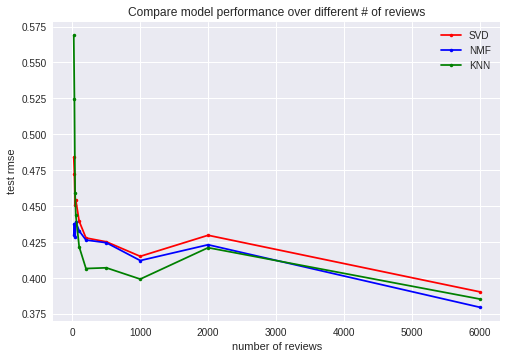

In [42]:
# visualize
x = [20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
y_svd = svd_err['SVD'].values.tolist()
y_nmf = nmf_err['NMF'].values.tolist()
y_knn = knn_err['KNN'].values.tolist()

plt.plot(x, y_svd, '.r-') 
plt.plot(x, y_nmf, '.b-') 
plt.plot(x, y_knn, '.g-') 
plt.legend(('SVD', 'NMF', 'KNN'), loc='upper right')

plt.xlabel('number of reviews')
plt.ylabel('test rmse')
plt.title('Compare model performance over different # of reviews')

plt.show()

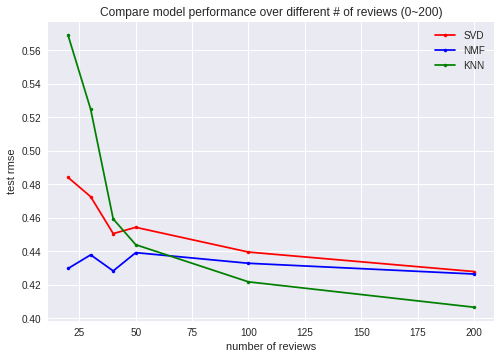

In [43]:
# visualize: reviews 10-200

x = [20, 30, 40, 50, 100, 200]
y_svd = svd_err['SVD'].values.tolist()[:6]
y_nmf = nmf_err['NMF'].values.tolist()[:6]
y_knn = knn_err['KNN'].values.tolist()[:6]

plt.plot(x, y_svd, '.r-') 
plt.plot(x, y_nmf, '.b-') 
plt.plot(x, y_knn, '.g-') 
plt.legend(('SVD', 'NMF', 'KNN'), loc='upper right')

plt.xlabel('number of reviews')
plt.ylabel('test rmse')
plt.title('Compare model performance over different # of reviews (0~200)')

plt.show()